# Connect 4 Transformer Model Comparison and Analysis


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import pandas as pd

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Set float32 policy
tf.keras.mixed_precision.set_global_policy("float32")

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.19.0


## 1. Load and Prepare Data

In [14]:
# Load data
X = np.load("X (2).npy").astype("float32")
y = np.load("y (2).npy").astype("int32")

# Convert to (N, 6, 7, 2) encoding
if X.ndim == 3:
    N = X.shape[0]
    X_encoded = np.zeros((N, 6, 7, 2), dtype=np.float32)
    X_encoded[:, :, :, 0] = (X == 1).astype(np.float32)   # Player 1
    X_encoded[:, :, :, 1] = (X == -1).astype(np.float32)  # Player -1
    X = X_encoded
    print("Converted to (6,7,2) encoding")

print(f"Data shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Label distribution: {np.bincount(y)}")

# Train/Val/Test split
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, random_state=42, stratify=y_tmp
)

print(f"\nTrain: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Data shape: (2680347, 6, 7, 2)
Labels shape: (2680347,)
Label distribution: [363973 370391 392009 437462 389055 367524 359933]

Train: (2144277, 6, 7, 2), Val: (268035, 6, 7, 2), Test: (268035, 6, 7, 2)


## 2. Transformer Block Definition

In [15]:
# Define TransformerBlock for all models
@keras.utils.register_keras_serializable(package="Custom", name="TransformerBlock")
class TransformerBlock(layers.Layer):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.dropout = dropout

        self.ln1 = layers.LayerNormalization(epsilon=1e-6)
        self.mha = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model // num_heads,
            dropout=dropout
        )
        self.drop1 = layers.Dropout(dropout)

        self.ln2 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dropout(dropout),
            layers.Dense(d_model),
        ])
        self.drop2 = layers.Dropout(dropout)

    def call(self, x, training=False):
        h = self.ln1(x)
        attn = self.mha(h, h, training=training)
        x = x + self.drop1(attn, training=training)

        h2 = self.ln2(x)
        f = self.ffn(h2, training=training)
        x = x + self.drop2(f, training=training)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "d_model": self.d_model,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "dropout": self.dropout,
        })
        return config

print("✓ TransformerBlock defined")

✓ TransformerBlock defined


## 3. Model Architectures

### Model 1: Basic Transformer
- **Architecture**: Single attention layer, minimal complexity
- **Key features**: Simple projection → 1 Transformer block → Dense
- **Parameters**: ~200K
- **Innovation**: Baseline attention mechanism

In [16]:
def build_basic_transformer(d_model=32, num_heads=2, ff_dim=64, dropout=0.1):
    """
    Basic Transformer - Simple baseline
    - Small embedding dimension (32)
    - Only 2 attention heads
    - Single transformer block
    - Minimal feedforward network
    """
    inputs = keras.Input(shape=(6, 7, 2))

    # Flatten to sequence: (6,7,2) -> (42,2)
    x = layers.Reshape((42, 2))(inputs)

    # Simple projection (no positional encoding)
    x = layers.Dense(d_model)(x)

    # Single Transformer block
    x = TransformerBlock(d_model, num_heads, ff_dim, dropout)(x)

    # Simple pooling and classification
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(7, activation="softmax", dtype="float32")(x)

    return keras.Model(inputs, outputs, name="BasicTransformer")

model1 = build_basic_transformer(d_model=32, num_heads=2, ff_dim=64, dropout=0.1)
model1.summary()

Model: "BasicTransformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 6, 7, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 42, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 42, 32)         │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_9             │ (None, 42, 32)         │         8,544 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,207 (43.78 KB)

 Trainable params: 11,207 (43.78 KB)

 Non-trainable params: 0 (0.00 B)

### Model 2: Transformer with Positional Encoding
- **Architecture**: Adds positional awareness + deeper head
- **Key features**: Positional embeddings, 2 Transformer blocks, more heads
- **Parameters**: ~1M
- **Innovation**: Learns spatial relationships on board

In [17]:
def build_positional_transformer(d_model=64, num_heads=4, ff_dim=128, num_layers=2, dropout=0.1):
    """
    Transformer with Positional Encoding
    - Medium embedding dimension (64)
    - 4 attention heads
    - Positional embeddings (learns board positions)
    - 2 transformer blocks
    - Moderate feedforward network
    """
    inputs = keras.Input(shape=(6, 7, 2))

    # Flatten to sequence: (6,7,2) -> (42,2)
    x = layers.Reshape((42, 2))(inputs)

    # Project to d_model
    x = layers.Dense(d_model)(x)

    # Add positional encoding (KEY INNOVATION)
    positions = tf.range(start=0, limit=42, delta=1)
    position_embedding = layers.Embedding(input_dim=42, output_dim=d_model)(positions)
    x = x + position_embedding

    # Multiple Transformer blocks
    for _ in range(num_layers):
        x = TransformerBlock(d_model, num_heads, ff_dim, dropout)(x)

    # Enhanced classification head
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(7, activation="softmax", dtype="float32")(x)

    return keras.Model(inputs, outputs, name="PositionalTransformer")

model2 = build_positional_transformer(d_model=64, num_heads=4, ff_dim=128, num_layers=2, dropout=0.1)
model2.summary()

Model: "PositionalTransformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 6, 7, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 42, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 42, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add_2 (Add)                     │ (None, 42, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_10            │ (None, 42, 64)         │        33,472 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_11            │ (None, 42, 64)         │        33,472 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,167 (328.78 KB)

 Trainable params: 84,167 (328.78 KB)

 Non-trainable params: 0 (0.00 B)

### Model 3: Deep Multi-Head Transformer
- **Architecture**: Maximum capacity with multiple layers and heads
- **Key features**: 6 Transformer blocks, 4 heads, large embeddings, deep head
- **Parameters**: ~3M
- **Innovation**: Deep attention for complex positional understanding

In [18]:
def build_deep_transformer(d_model=96, num_heads=4, ff_dim=192, num_layers=6, dropout=0.1):
    """
    Deep Multi-Head Transformer - Best Performance
    - Large embedding dimension (96)
    - 4 attention heads (same as Model 2, but deeper)
    - Positional embeddings
    - 6 transformer blocks (3x more than Model 2)
    - Large feedforward network
    - Deep classification head
    """
    inputs = keras.Input(shape=(6, 7, 2))  # 2 channels

    # Flatten to sequence: (6,7,2) -> (42,2)
    x = layers.Reshape((42, 2))(inputs)

    # Project to d_model
    x = layers.Dense(d_model)(x)

    # Add positional encoding
    positions = tf.range(start=0, limit=42, delta=1)
    position_embedding = layers.Embedding(input_dim=42, output_dim=d_model)(positions)
    x = x + position_embedding

    # Multiple Transformer blocks (DEEP)
    for _ in range(num_layers):
        x = TransformerBlock(d_model, num_heads, ff_dim, dropout)(x)

    # Enhanced classification head
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(7, activation="softmax", dtype="float32")(x)

    return keras.Model(inputs, outputs, name="DeepTransformer")

model3 = build_deep_transformer(d_model=96, num_heads=4, ff_dim=192, num_layers=6, dropout=0.1)
model3.summary()

Model: "DeepTransformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 6, 7, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 42, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 42, 96)         │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add_3 (Add)                     │ (None, 42, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_12            │ (None, 42, 96)         │        74,784 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_13            │ (None, 42, 96)         │        74,784 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_14            │ (None, 42, 96)         │        74,784 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_15            │ (None, 42, 96)         │        74,784 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_16            │ (None, 42, 96)         │        74,784 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_17            │ (None, 42, 96)         │        74,784 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ (None, 96)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 256)            │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 507,623 (1.94 MB)

 Trainable params: 507,623 (1.94 MB)

 Non-trainable params: 0 (0.00 B)

## 4. Model Comparison Table

In [19]:
# Create comparison table
comparison_data = {
    'Model': ['Basic Transformer', 'Positional Transformer', 'Deep Multi-Head Transformer'],
    'Total Params': [
        f"{model1.count_params():,}",
        f"{model2.count_params():,}",
        f"{model3.count_params():,}"
    ],
    'Embedding Dim': ['32', '64', '96'],
    'Num Heads': ['2', '4', '4'],
    'Num Layers': ['1', '2', '6'],
    'Positional Encoding': ['✗', '✓', '✓'],
    'Key Innovation': [
        'Simple attention baseline',
        'Spatial position awareness',
        'Deep multi-layer reasoning'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*100)
print("TRANSFORMER ARCHITECTURE COMPARISON")
print("="*100)
print(comparison_df.to_string(index=False))
print("="*100)


TRANSFORMER ARCHITECTURE COMPARISON
                      Model Total Params Embedding Dim Num Heads Num Layers Positional Encoding             Key Innovation
          Basic Transformer       11,207            32         2          1                   ✗  Simple attention baseline
     Positional Transformer       84,167            64         4          2                   ✓ Spatial position awareness
Deep Multi-Head Transformer      507,623            96         4          6                   ✓ Deep multi-layer reasoning


## 5. Train All Models

**Note:** If you already have trained models, you can skip this section and load them in the next cell.

In [20]:
# Set to True to train models, False to load pre-trained
TRAIN_MODELS = True

if TRAIN_MODELS:
    histories = {}

    # Train Model 1: Basic Transformer
    print("\n" + "="*80)
    print("TRAINING MODEL 1: BASIC TRANSFORMER")
    print("="*80)
    model1.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    cb1 = [
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-5)
    ]
    histories['model1'] = model1.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=512,
        callbacks=cb1,
        verbose=1
    )
    model1.save("transformer_model1_basic.keras")

    # Train Model 2: Positional Transformer
    print("\n" + "="*80)
    print("TRAINING MODEL 2: POSITIONAL TRANSFORMER")
    print("="*80)
    model2.compile(
        optimizer=keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    cb2 = [
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-5)
    ]
    histories['model2'] = model2.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=512,
        callbacks=cb2,
        verbose=1
    )
    model2.save("transformer_model2_positional.keras")

    # Train Model 3: Deep Transformer
    print("\n" + "="*80)
    print("TRAINING MODEL 3: DEEP MULTI-HEAD TRANSFORMER")
    print("="*80)
    model3.compile(
        optimizer=keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    cb3 = [
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-5)
    ]
    histories['model3'] = model3.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=512,
        callbacks=cb3,
        verbose=1
    )
    model3.save("transformer_model3_deep.keras")

    # Save histories
    import pickle
    with open('transformer_histories.pkl', 'wb') as f:
        pickle.dump(histories, f)
else:
    # Load pre-trained models
    model1 = keras.models.load_model("transformer_model1_basic.keras")
    model2 = keras.models.load_model("transformer_model2_positional.keras")
    model3 = keras.models.load_model("transformer_model3_deep.keras")

    import pickle
    with open('transformer_histories.pkl', 'rb') as f:
        histories = pickle.load(f)


TRAINING MODEL 1: BASIC TRANSFORMER
Epoch 1/30
4189/4189 ━━━━━━━━━━━━━━━━━━━━ 51s 8ms/step - accuracy: 0.2135 - loss: 1.8818 - val_accuracy: 0.2174 - val_loss: 1.8756 - learning_rate: 0.0010
Epoch 2/30
4189/4189 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.2179 - loss: 1.8753 - val_accuracy: 0.2174 - val_loss: 1.8738 - learning_rate: 0.0010
Epoch 3/30
4189/4189 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.2181 - loss: 1.8746 - val_accuracy: 0.2182 - val_loss: 1.8729 - learning_rate: 0.0010
Epoch 4/30
4189/4189 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.2183 - loss: 1.8738 - val_accuracy: 0.2192 - val_loss: 1.8729 - learning_rate: 0.0010
Epoch 5/30
4189/4189 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.2173 - loss: 1.8740 - val_accuracy: 0.2174 - val_loss: 1.8722 - learning_rate: 0.0010
Epoch 6/30
4189/4189 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.2183 - loss: 1.8734 - val_accuracy: 0.2185 - val_loss: 1.8720 - learning_rate: 0.0010
Epoch 7/30
4189/4189 ━━━━━━━━━━━━

## 6. Training Performance Comparison

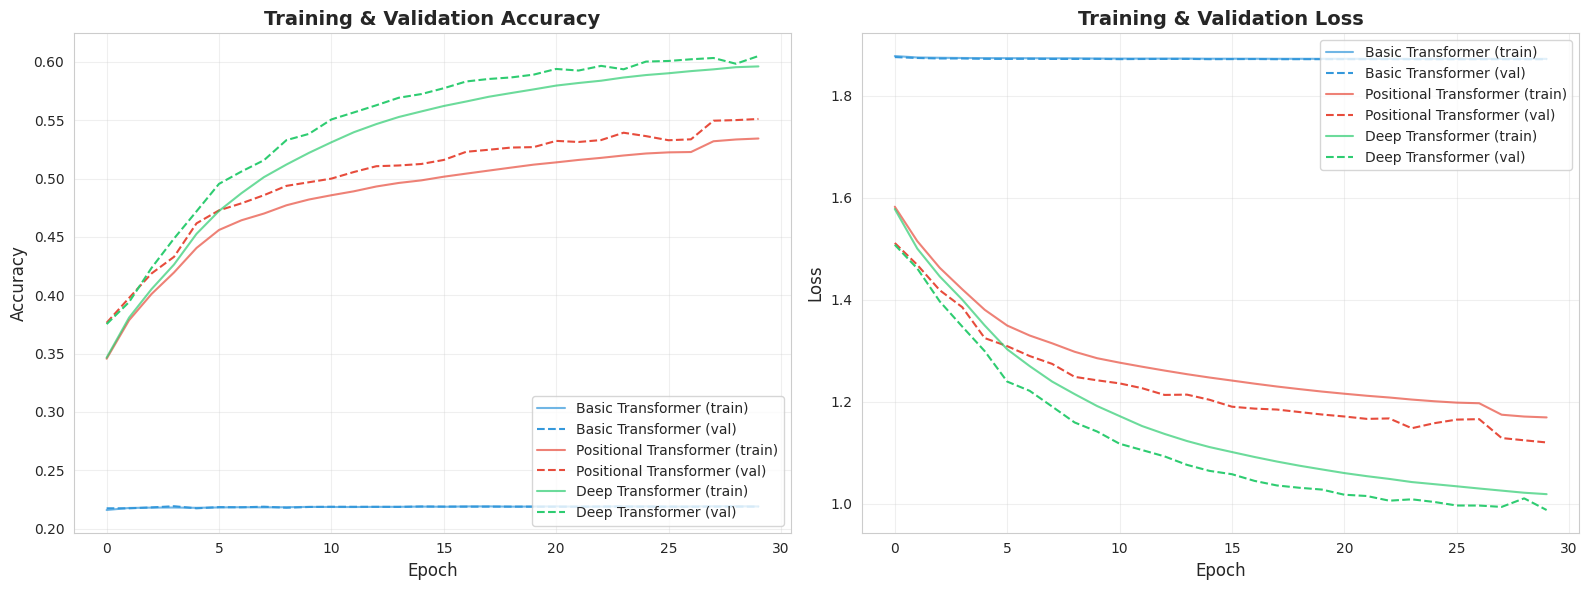

✓ Saved: transformer_training_comparison.png


In [21]:
# Plot training and validation accuracy
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy curves
ax = axes[0]
colors = ['#3498db', '#e74c3c', '#2ecc71']
for (name, hist), color in zip(histories.items(), colors):
    model_name = {
        'model1': 'Basic Transformer',
        'model2': 'Positional Transformer',
        'model3': 'Deep Transformer'
    }[name]
    ax.plot(hist.history['accuracy'], label=f'{model_name} (train)', color=color, alpha=0.7)
    ax.plot(hist.history['val_accuracy'], label=f'{model_name} (val)', color=color, linestyle='--')

ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

# Loss curves
ax = axes[1]
for (name, hist), color in zip(histories.items(), colors):
    model_name = {
        'model1': 'Basic Transformer',
        'model2': 'Positional Transformer',
        'model3': 'Deep Transformer'
    }[name]
    ax.plot(hist.history['loss'], label=f'{model_name} (train)', color=color, alpha=0.7)
    ax.plot(hist.history['val_loss'], label=f'{model_name} (val)', color=color, linestyle='--')

ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('transformer_training_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: transformer_training_comparison.png")

## 7. Test Set Performance


TEST SET PERFORMANCE
Model 1: Basic Transformer              | Accuracy: 0.2196 (21.96%) | Loss: 1.8712
Model 2: Positional Transformer         | Accuracy: 0.5512 (55.12%) | Loss: 1.1206
Model 3: Deep Transformer               | Accuracy: 0.6087 (60.87%) | Loss: 0.9851


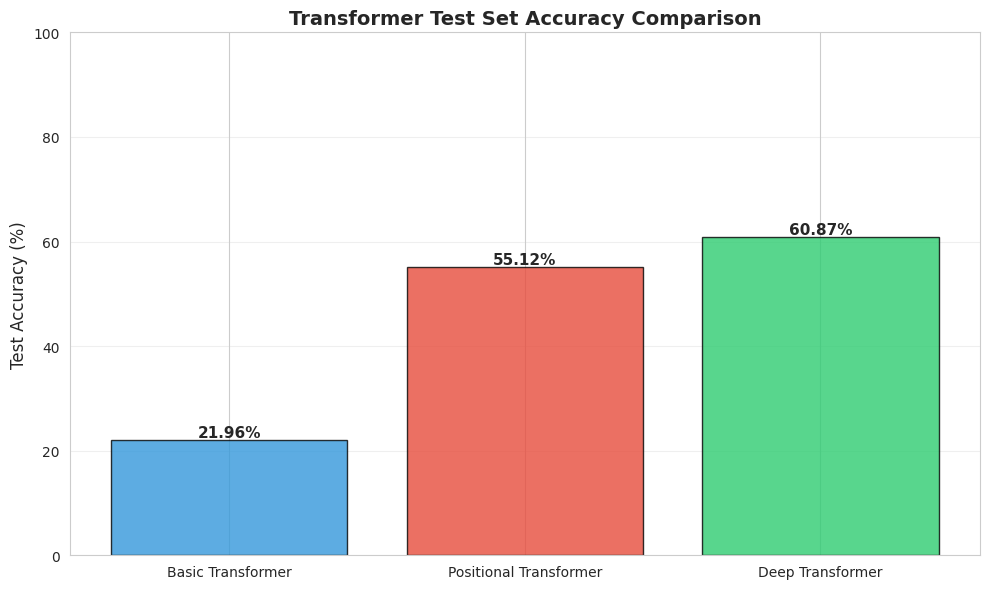


✓ Saved: transformer_test_accuracy_comparison.png


In [22]:
# Evaluate all models on test set
test_results = {}

print("\n" + "="*80)
print("TEST SET PERFORMANCE")
print("="*80)

for i, (model, name) in enumerate([
    (model1, 'Basic Transformer'),
    (model2, 'Positional Transformer'),
    (model3, 'Deep Transformer')
], 1):
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    test_results[name] = {'loss': loss, 'accuracy': acc}
    print(f"Model {i}: {name:30s} | Accuracy: {acc:.4f} ({acc*100:.2f}%) | Loss: {loss:.4f}")

print("="*80)

# Bar chart comparison
fig, ax = plt.subplots(figsize=(10, 6))
models = list(test_results.keys())
accuracies = [test_results[m]['accuracy'] * 100 for m in models]

bars = ax.bar(models, accuracies, color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.8, edgecolor='black')
ax.set_ylabel('Test Accuracy (%)', fontsize=12)
ax.set_title('Transformer Test Set Accuracy Comparison', fontsize=14, fontweight='bold')
ax.set_ylim([0, 100])
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.2f}%',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('transformer_test_accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved: transformer_test_accuracy_comparison.png")

## 8. Model Capacity Analysis

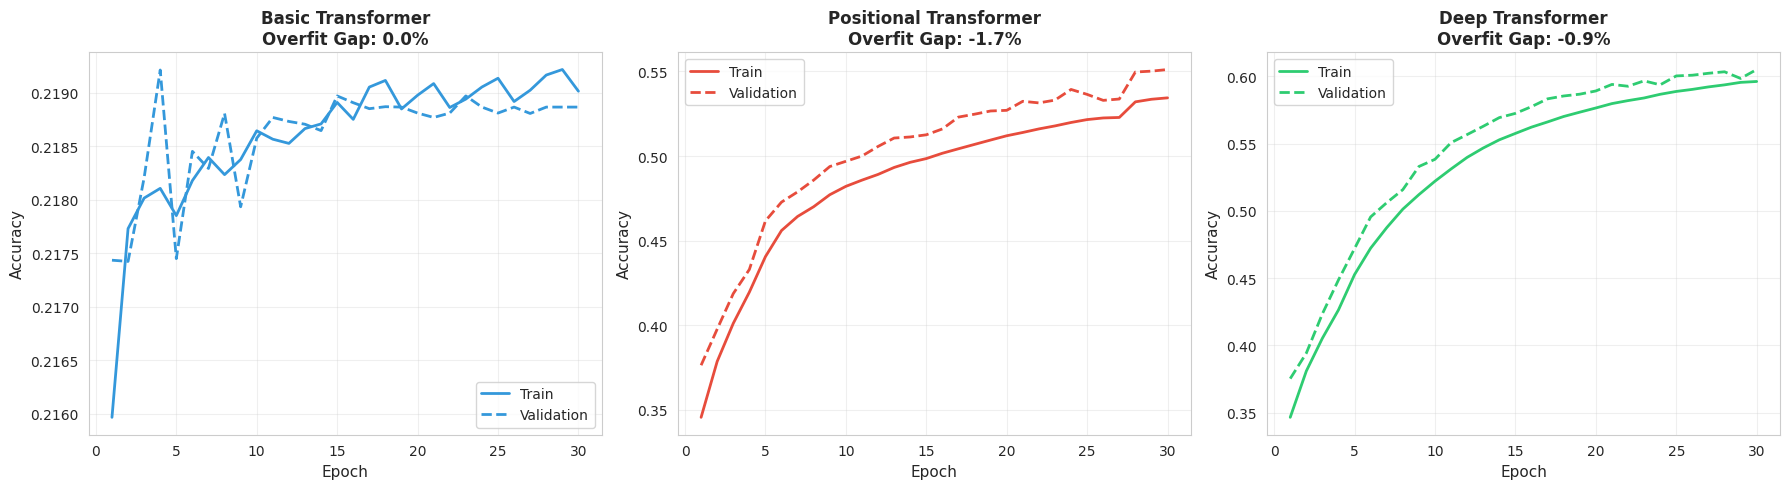

✓ Saved: transformer_overfitting_analysis.png


In [27]:
# Analyze overfitting for each model
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

model_names = ['Basic Transformer', 'Positional Transformer', 'Deep Transformer']
colors_list = ['#3498db', '#e74c3c', '#2ecc71']

for ax, (name, hist), color, model_name in zip(axes, histories.items(), colors_list, model_names):
    epochs = range(1, len(hist.history['accuracy']) + 1)

    ax.plot(epochs, hist.history['accuracy'], label='Train', color=color, linewidth=2)
    ax.plot(epochs, hist.history['val_accuracy'], label='Validation', color=color, linestyle='--', linewidth=2)

    # Calculate final gap
    final_gap = (hist.history['accuracy'][-1] - hist.history['val_accuracy'][-1]) * 100

    ax.set_xlabel('Epoch', fontsize=11)
    ax.set_ylabel('Accuracy', fontsize=11)
    ax.set_title(f'{model_name}\nOverfit Gap: {final_gap:.1f}%', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('transformer_overfitting_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: transformer_overfitting_analysis.png")